In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

import time
from collections import Counter
import string
import re
import contractions

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/fake-news/train.csv', header=0)
test_df = pd.read_csv('/content/drive/My Drive/fake-news/test.csv', header=0)

In [ ]:
train_df.head(2)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


## Data Analysis

In [ ]:
print("train_dataset\n" ,train_df.isna().sum())
print("test_dataset\n",test_df.isna().sum())

train_dataset
 id           0
title      558
author    1957
text        39
label        0
dtype: int64
test_dataset
 id          0
title     122
author    503
text        7
dtype: int64


In [ ]:
train_df.dropna(axis=0, how='any',inplace=True)
test_df = test_df.fillna(' ')

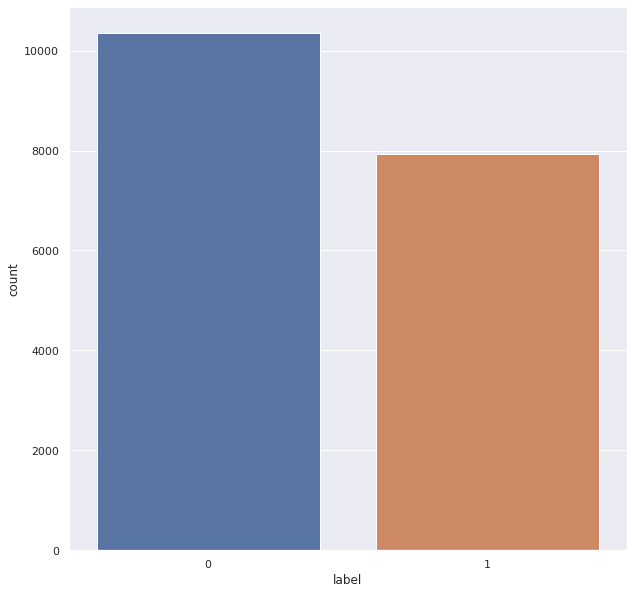

In [ ]:
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10, 10]
sns.set_theme(style="darkgrid")
sns.countplot(x='label', data=train_df)
plt.show()

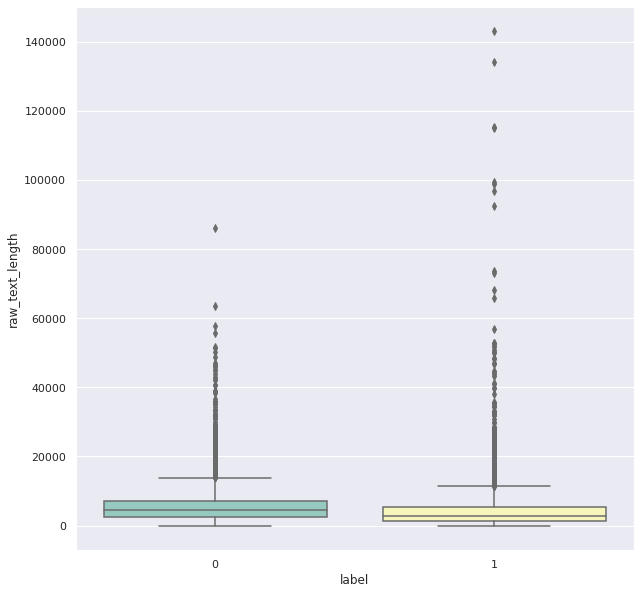

In [ ]:
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
sns.boxplot(y='raw_text_length', x='label', data=train_df, palette="Set3")
plt.show()

In [ ]:
train_df.describe()

,id,label,raw_text_length
count,18285.000000,18285.000000,18285.000000
mean,10409.807383,0.433361,4800.181843
std,5998.216236,0.495553,5225.865069
min,0.000000,0.000000,1.000000
25%,5217.000000,0.000000,1834.000000
50%,10422.000000,0.000000,3694.000000
75%,15603.000000,1.000000,6535.000000
max,20799.000000,1.000000,142961.000000


In [ ]:
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))

74


In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/fake-news/train.csv', header=0)
train_df = train_df.fillna(' ')
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))
print(train_df.isna().sum())
train_df = train_df[train_df['raw_text_length'] > 0]
print(train_df.shape)
print(train_df.isna().sum())

116
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64
(20684, 6)
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64


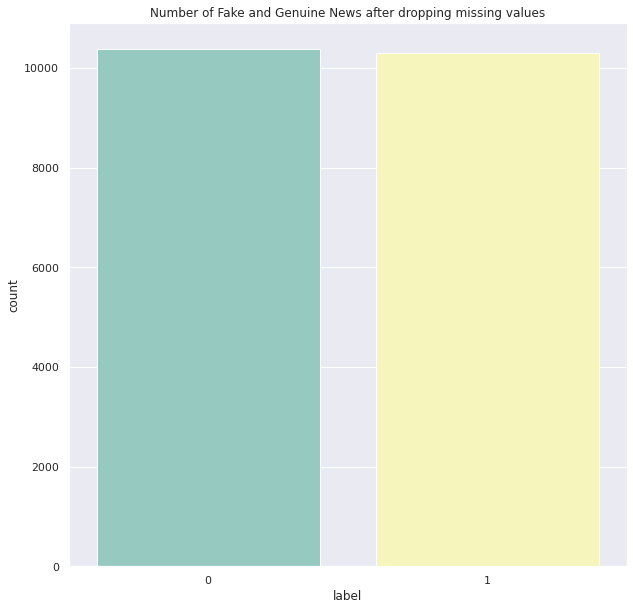

In [ ]:
sns.countplot(x='label', data=train_df, palette='Set3')
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

## Text Preprocessing

In [ ]:
gen_news_authors = set(list(train_df[train_df['label']==0]['author'].unique()))
fake_news_authors = set(list(train_df[train_df['label']==1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: ", len(gen_news_authors))
print("Number of distinct authors with fake articles: ", len(fake_news_authors))
print("Number of distinct authors with both genuine and fake: ", len(overlapped_authors))

Number of distinct authors with genuine articles:  2226
Number of distinct authors with fake articles:  1976
Number of distinct authors with both genuine and fake:  6


In [ ]:
original_train_df = train_df.copy() 

In [ ]:
def preprocess_text(x):
  cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
  word_list = []
  for each_word in cleaned_text.split(' '):
    try:
      word_list.append(contractions.fix(each_word).lower()) 
    except:
      print(x)
  return " ".join(word_list)
  
text_cols = ['text', 'title', 'author']
for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
  test_df[col] = test_df[col].apply(lambda x: preprocess_text(x)) 

Processing column: text
Processing column: title
Processing column: author


In [ ]:
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(word_tokenize)
    test_df[col] = test_df[col].apply(word_tokenize)

for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])
    test_df[col] = test_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
Processing column: text
Processing column: title
Processing column: author


In [ ]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))
target = train_df['label'].values

## Text Analysis

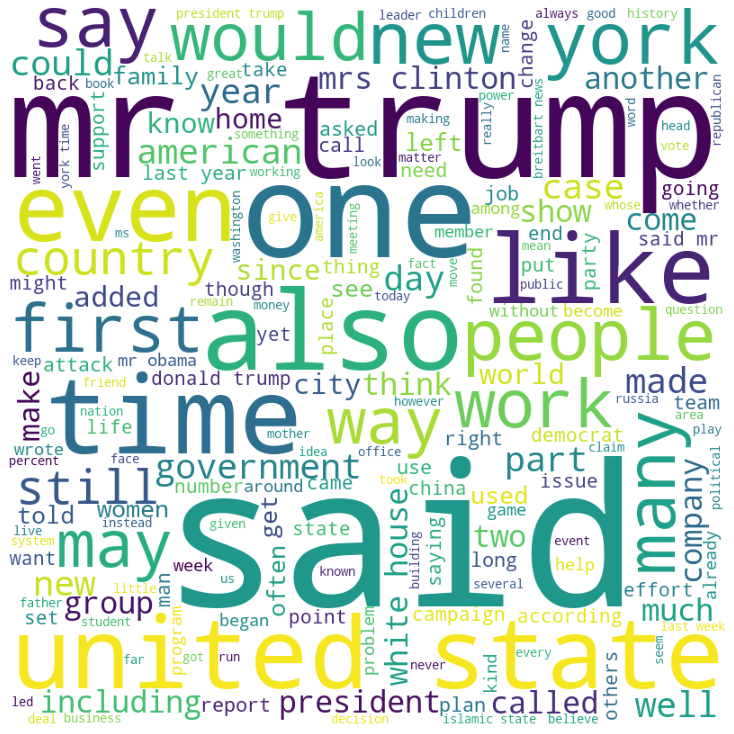

In [ ]:
# join all texts in resective labels
all_texts_gen = " ".join(train_df[train_df['label']==0]['text_joined'])
all_texts_fake = " ".join(train_df[train_df['label']==1]['text_joined'])

# Wordcloud for Genuine News
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_gen)                       
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

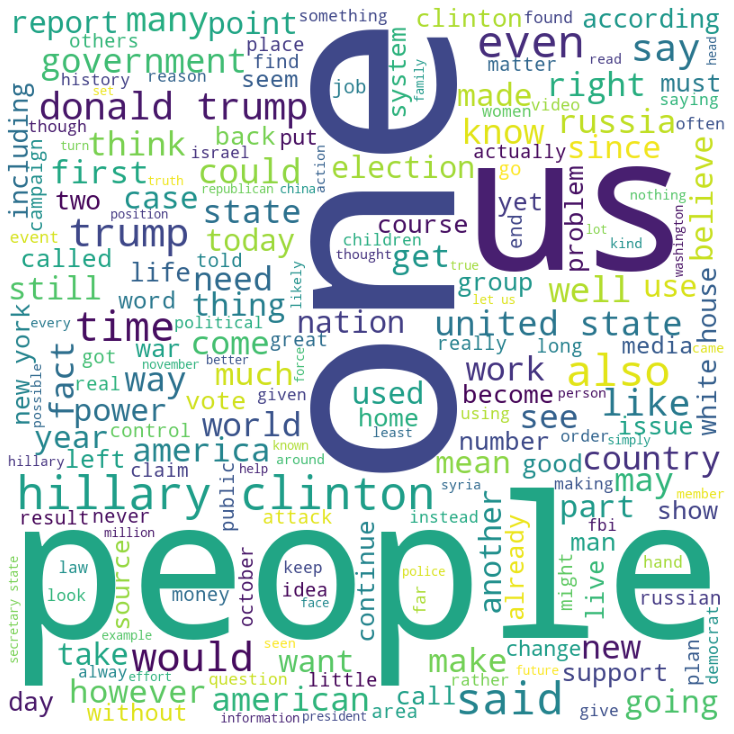

In [ ]:
# Worldcloud for Fake News
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_fake)                    
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## Stylometric Analysis

In [ ]:
original_train_df['sent_tokens'] = original_train_df['text'].apply(sent_tokenize)

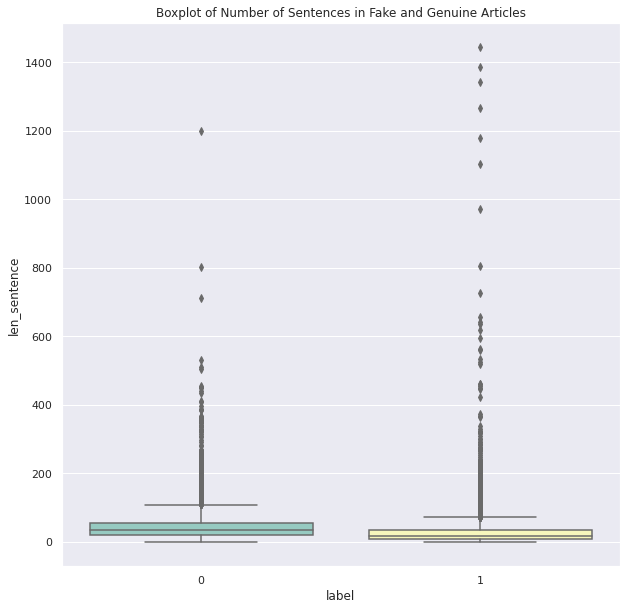

In [ ]:
original_train_df['len_sentence'] = original_train_df['sent_tokens'].apply(len)
sns.boxplot(y='len_sentence', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of Number of Sentences in Fake and Genuine Articles")
plt.show()

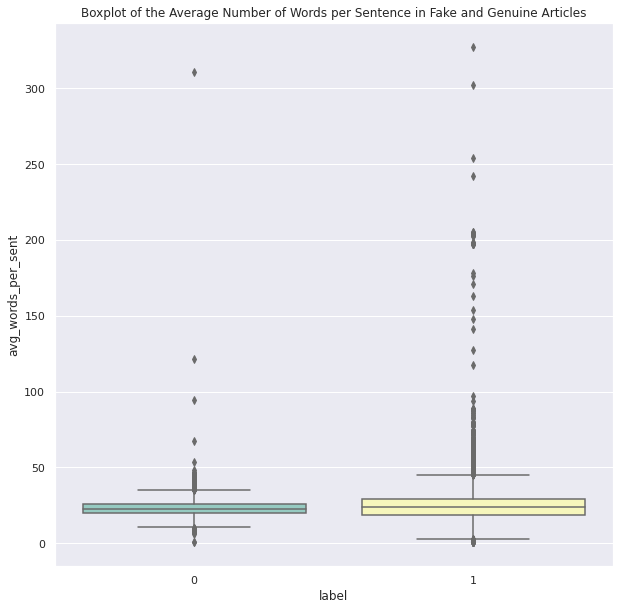

In [ ]:
# tokenize words within the sequences
original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(lambda x: [word_tokenize(each_sentence) for each_sentence in x])

# Clean the punctuations
def get_seq_tokens_cleaned(seq_tokens):
  no_punc_seq = [each_seq.translate(str.maketrans('', '', string.punctuation)) for each_seq in seq_tokens]
  sent_word_tokens = [word_tokenize(each_sentence) for each_sentence in no_punc_seq]
  return sent_word_tokens

# Count the avg number of words in each sentence
def get_average_words_in_sent(seq_word_tokens):
  return np.mean([len(seq) for seq in seq_word_tokens])

original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(lambda x: get_seq_tokens_cleaned(x))
original_train_df['avg_words_per_sent'] = original_train_df['sent_word_tokens'].apply(lambda x: get_average_words_in_sent(x))

sns.boxplot(y='avg_words_per_sent', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")

plt.show()

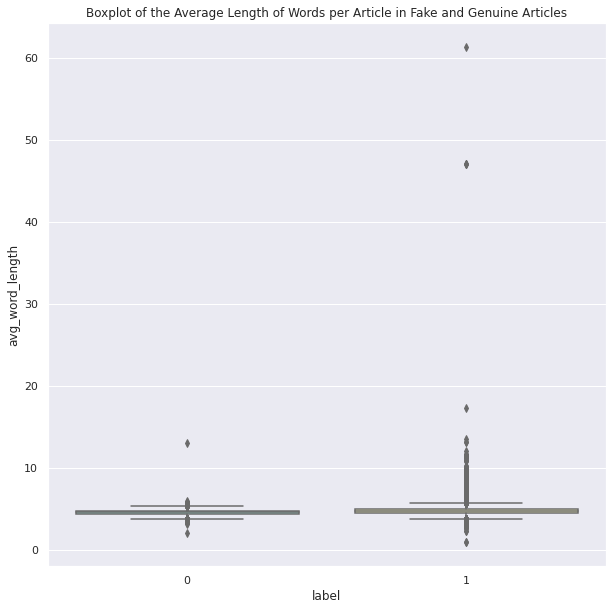

In [ ]:
def get_average_word_length(seq_word_tokens):
  return np.mean([len(word) for seq in seq_word_tokens for word in seq])

original_train_df['avg_word_length'] = original_train_df['sent_word_tokens'].apply(lambda x: get_average_word_length(x))

sns.boxplot(y='avg_word_length', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Length of Words per Article in Fake and Genuine Articles")
plt.show()

['RB', 'VB', 'VBG', 'NN', 'NNS']
['NN', 'NN', 'NN', 'RB', 'VB']


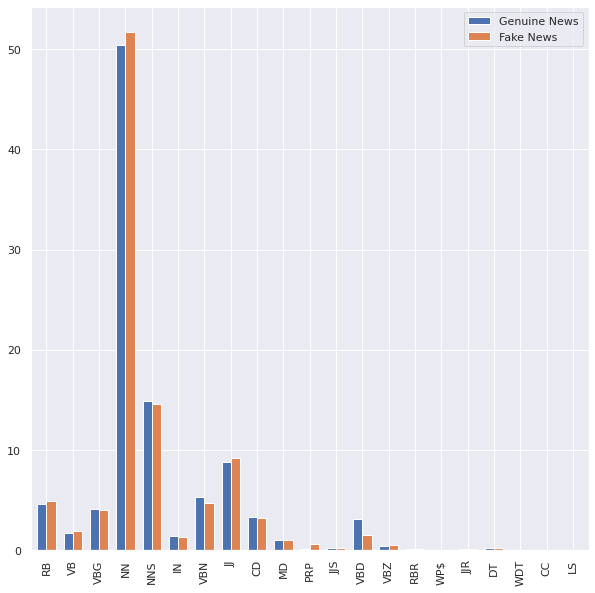

In [ ]:
all_tokenized_gen = [a for b in train_df[train_df['label']==0]['text'].tolist() for a in b]
all_tokenized_fake = [a for b in train_df[train_df['label']==1]['text'].tolist() for a in b]

def get_post_tags_list(tokenized_articles):
  all_pos_tags = []
  for word in tokenized_articles:
    pos_tag = nltk.pos_tag([word])[0][1]
    all_pos_tags.append(pos_tag)
  return all_pos_tags
    
all_pos_tagged_word_gen = get_post_tags_list(all_tokenized_gen)
all_pos_tagged_word_fake = get_post_tags_list(all_tokenized_fake)

print(all_pos_tagged_word_gen[:5])
print(all_pos_tagged_word_fake[:5])

gen_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_gen)).items(), columns=['Pos_tag', 'Genuine News'])
fake_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_fake)).items(), columns=['Pos_tag', 'Fake News'])
pos_df = gen_pos_df.merge(fake_pos_df, on='Pos_tag')

# Make percentage for comparison
pos_df['Genuine News'] = pos_df['Genuine News'] * 100 / pos_df['Genuine News'].sum()
pos_df['Fake News'] = pos_df['Fake News'] * 100 / pos_df['Fake News'].sum()
pos_df.head()

# plot a multiple bar chart
pos_df.plot.bar(width=0.7)
plt.xticks(range(0,len(pos_df['Pos_tag'])), pos_df['Pos_tag'])
plt.show()

## Text Classification using Machine Learning

In [ ]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit and transform train data to count vectorizer
count_vectorizer.fit(train_df['text_joined'].values)
count_vect_train = count_vectorizer.transform(train_df['text_joined'].values)

# fit the counts vector to tfidf transformer
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

# Transform the test data as well
count_vect_test = count_vectorizer.transform(test_df['text_joined'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

In [ ]:
df_perf_metrics = pd.DataFrame(columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])

# list to retain the models to use later for test set predictions
models_trained_list = []

def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [ ]:
models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 40.95 s.
Completed LogisticRegression model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.38 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 654.16 s.
Completed RandomForestClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 237.07 s.
Completed DecisionTreeClassifier model's performance assessment.
Training GradientBoostingClassifier model...


In [ ]:
df_perf_metrics